In [8]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [9]:
%load_ext autoreload
%autoreload 2
import cProfile
import importlib
import numpy as np
import os
import yaml
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, HELMConverter

config_path = "config/mcts_d_score_replication.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class, model_dir, lang_path = (conf.get(k) for k in ("model_class", "model_dir", "lang_path"))
if lang_path is None:
    lang_name = os.path.basename(os.path.normpath(model_dir)) + ".lang"
    lang_path = add_sep(model_dir) + lang_name
lang = Language.load(repo_root + lang_path)
model_class = class_from_package("transition", model_class)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class, reward_conf = (conf.get(k) for k in ("reward_class", "reward_conf"))
reward_conf = reward_conf or {}
reward_class = class_from_package("reward", reward_class)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class", "policy_conf"))
policy_class = class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class"))
    filters.append(filter_class(**s))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Search is started.
0- time: 0.01, count_rollouts: 1, reward: 0.0, node: CN1C(=O)[C@@H](OCC[C@H]2CCCC2)CS1
1- time: 0.01, count_rollouts: 2, reward: 0.2964686851443554, node: COc1cccc(-c2cnc(C)o2)c1C(=O)NC[C@@H](C)c1cccc(Cl)c1
2- time: 0.26, count_rollouts: 5, reward: 0.0, node: O=C(Nc1nc2ccccs12)c1ccccn1
3- time: 0.41, count_rollouts: 8, reward: 0.3360165381365441, node: NC(=O)c1cccc(Cn2cccc2)c1
4- time: 0.41, count_rollouts: 9, reward: 0.21262390303830944, node: N(Cc1ccccc1)Cc1cc(Br)c2c(c1)OCCO2
5- time: 0.58, count_rollouts: 11, reward: 0.25760493780485566, node: c1nnc(=O)c1NCCN1C(=O)N(C(=O)c2cccs2)CCC1
6- time: 0.77, count_rollouts: 14, reward: 0.1774714379739263, node: Fc1ccccc1N[C@H]1C[C@@H](Sc2ccc(Cl)cc2F)C1
7- time: 0.93, count_rollouts: 16, reward: 0.0, node: [NH3+]N(CCN1C[C@H](C)NC(=O)NCC1)c1cccc(OCC)c1
8- time: 1.11, count_rollouts: 21, reward: 0.2935600475088483, node: Clc1ccccc1CNC(=O)c1cc(OC)oc1
9- time: 1.26, count_rollouts: 23, reward: 0.0, node: SCOCc1noc(NCc2ccc(Cl)cc2

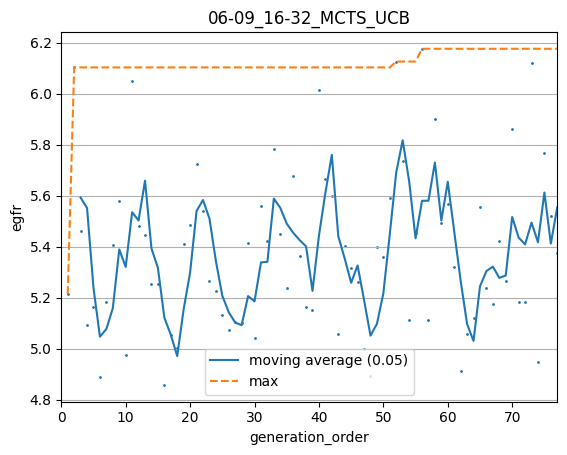

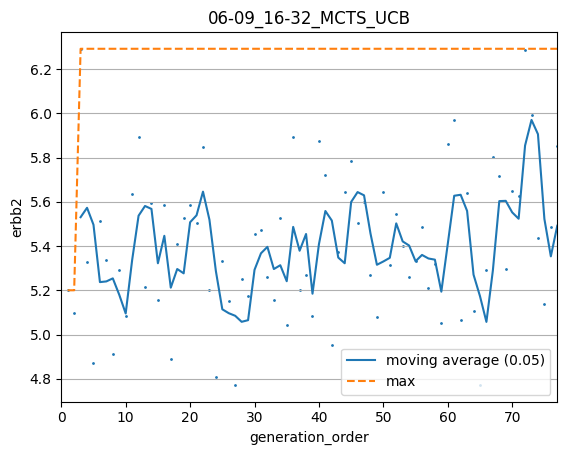

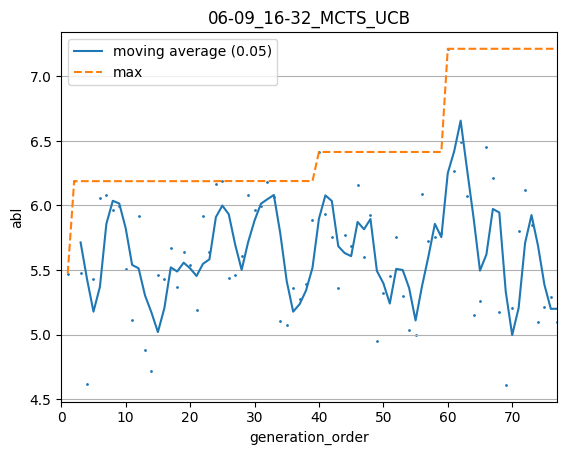

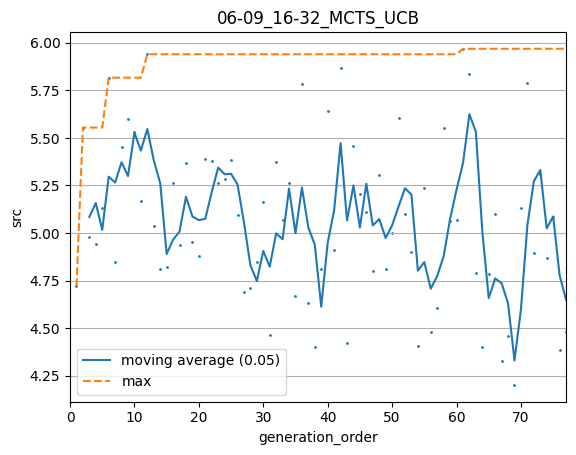

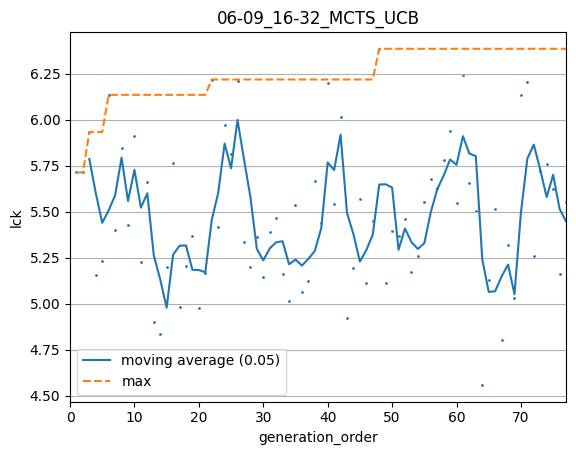

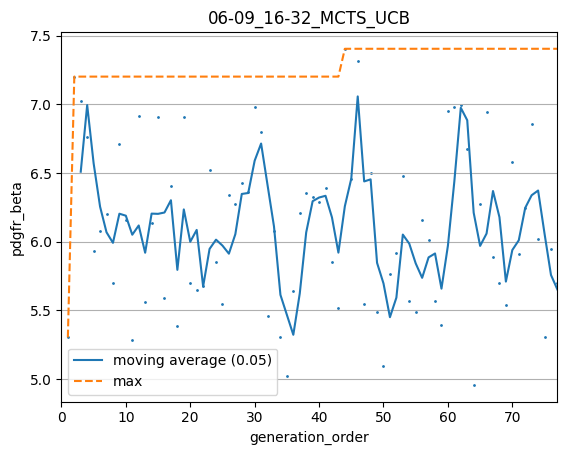

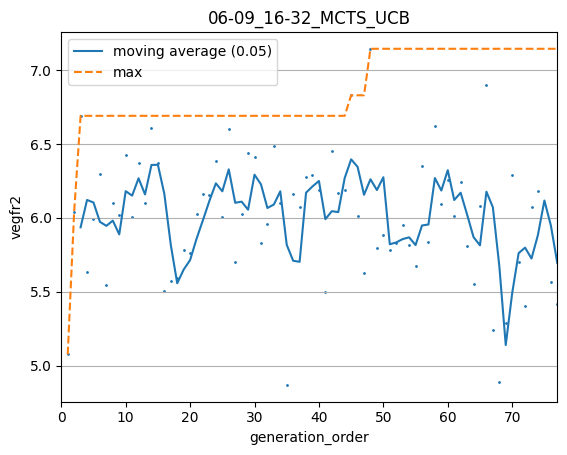

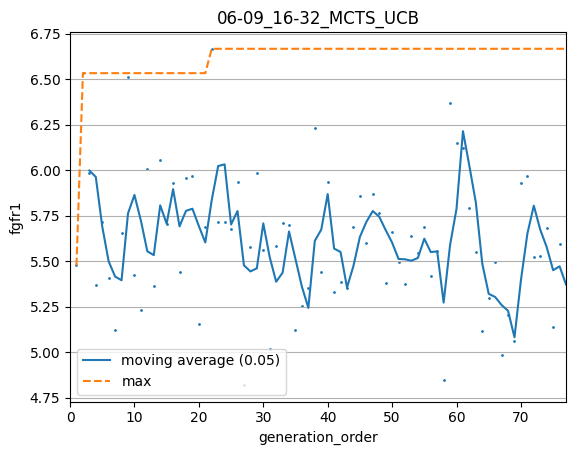

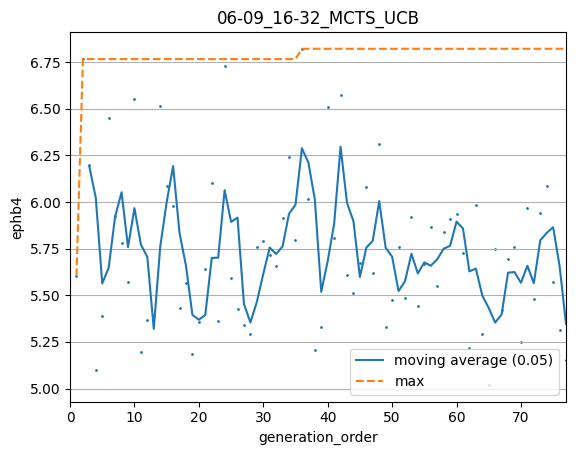

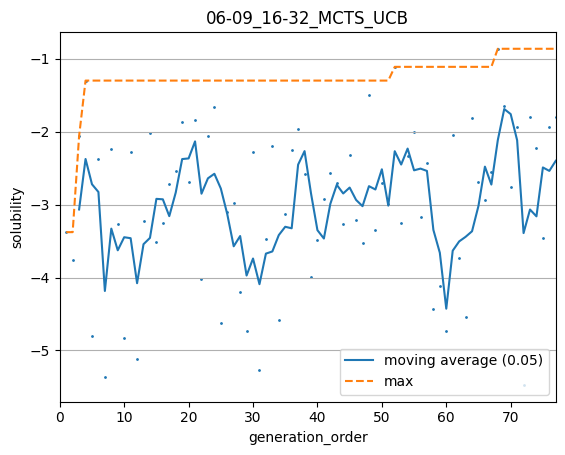

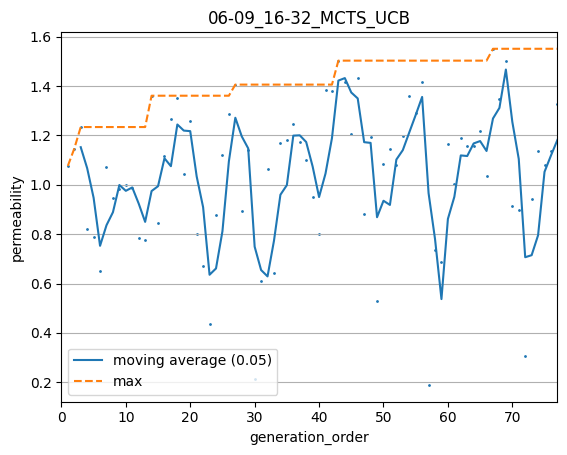

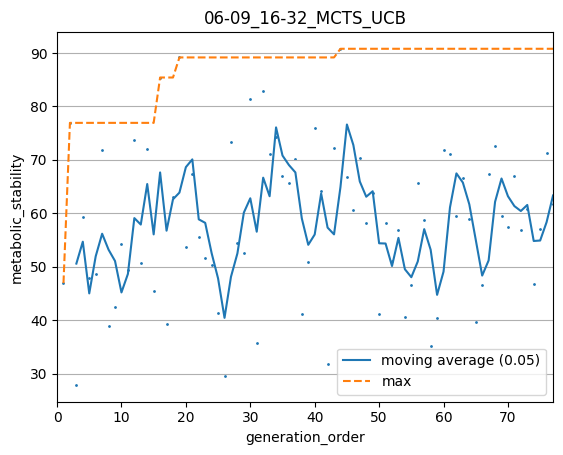

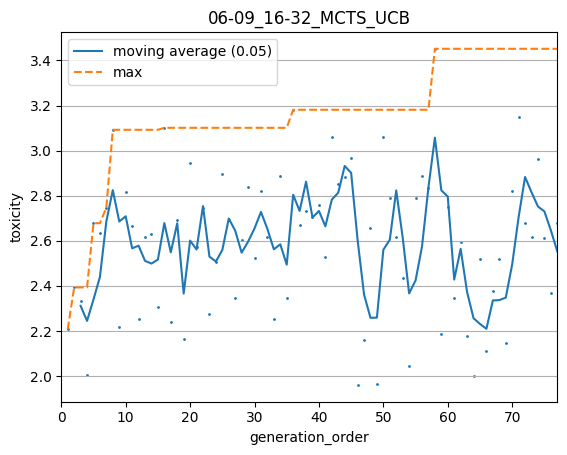

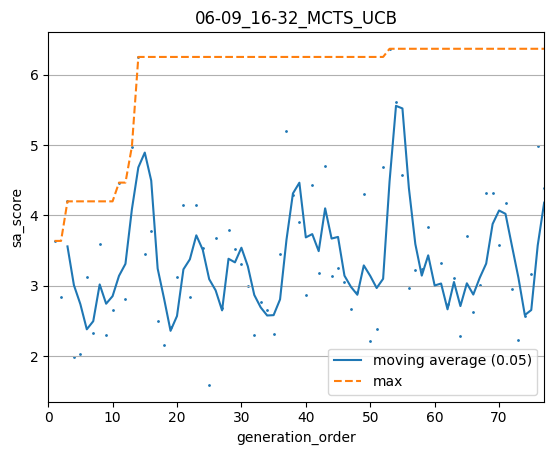

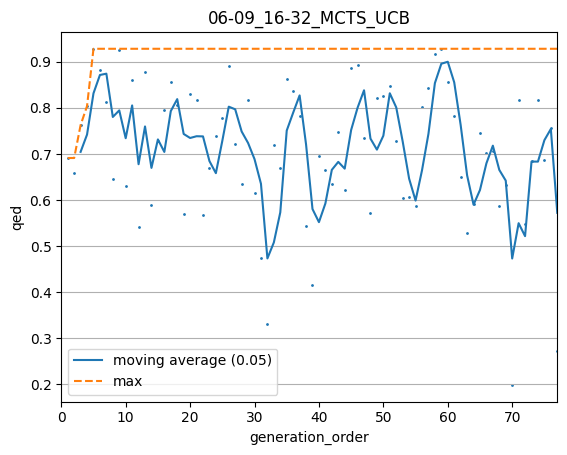

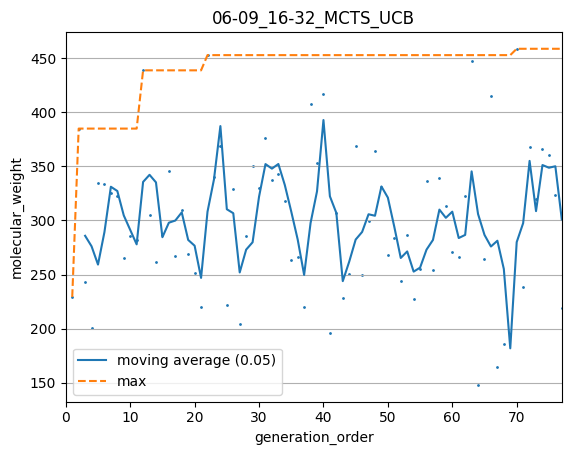

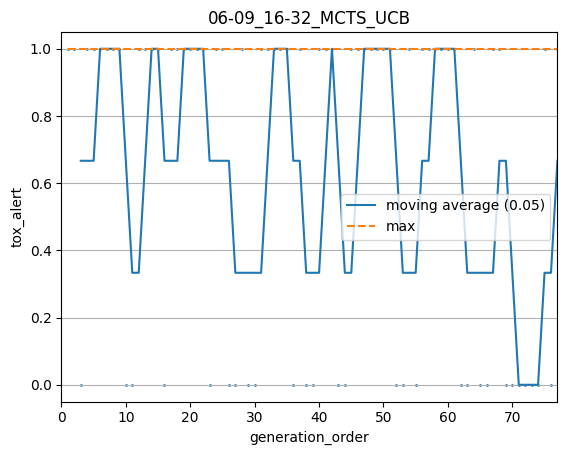

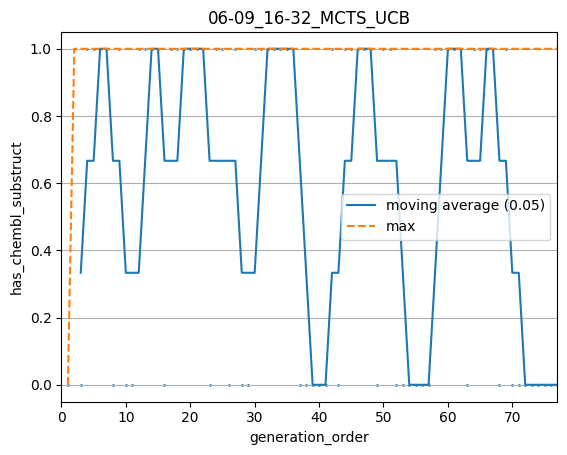

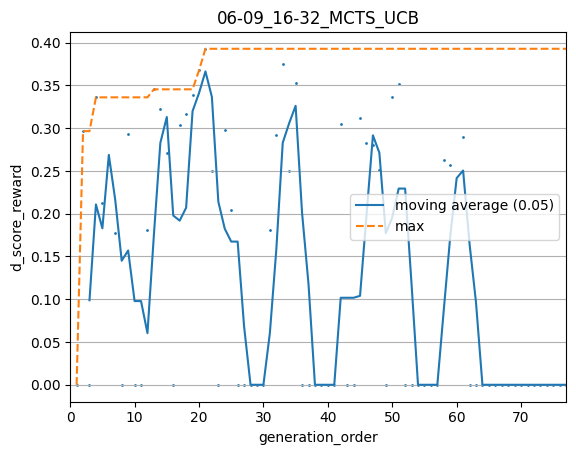

In [10]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') # invalid mols are already logged

root = MolSentenceNode.bos_node(lang) # TODO: change after root node generalization

output_dir, generation_conf, filtered_reward = (conf.get(k) for k in ("output_dir", "generation_conf", "filtered_reward"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, filtered_reward=filtered_reward, output_dir=output_dir)
src = repo_root + config_path
dst = generator.output_dir() + "setting.yaml"
shutil.copy(src, dst)

generator.generate(root=root, **generation_conf)
# cProfile.run("generator.generate(root=root, **generation_conf)"")

generator.plot_objective_values_and_reward(x_axis = "generation_order")
# generator.plot_objective_values_and_reward(x_axis = "time")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)